# Welcome

Please install a few Python dependencies via pip before you begin.

```
pip3 install matplotlib pandas pysnyk
```

### What do we want to achieve in the workshop

- Learn how `pysnyk` works roughly
- Navigate the basic `pysnyk` API
- Do management tasks:
  - find projects
  - change some fields for these projects
- Do reporting tasks
  - recreate 1 chart from dashboard
  - create a donut chart from something
- Encourage the SE team to work on these sheets to cover more usecases.

In [62]:
import snyk
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.dpi = 300

Let's get connected. We start by creating a SnykClient instance. This is the Python interface to the Snyk API.

For the string, create a service account in your Snyk backend and paste the token here.

Create a `SnykClient` instance and pass it a token, like from a Service Account. This is created in the Snyk backend. The constructor also takes other parameters for the URL (useful to test the EU instance). See details at https://pypi.org/project/pysnyk/.

**Note this project by default uses the V1 API**. It is possible to point it to V3 and get a raw HTTP Client, but there will be easier ways for that in the future using a generated OpenAPI client.

In [63]:
client = snyk.SnykClient("5d778343-78e7-4c73-9ba6-55af47a2f6af")

We fetch all organisations and print them in a table. _Ignore the `_client` column_.

In [64]:
orgs = client.organizations.all()

pd.DataFrame(orgs)

SnykHTTPError: <Response [401]>

Let's have a quick excursion into `pandas`. The `DataFrame` object actually has methods to learn about it, like `.columns`. 

In [4]:
pd.DataFrame(orgs).columns

Index(['name', 'id', 'slug', 'url', 'group', 'client'], dtype='object')

With that knowledge, let's only extract 2 columns and read.

In [5]:
pd.DataFrame(orgs)[['id', 'name']]

,id,name
0,4d0ac6a1-9e83-40de-b6ec-df7a723fe532,GL Test
1,c6d37704-5daa-41ad-9ca8-33a5b55b4872,.Net World
2,47d53b9a-81ad-49c0-8cb5-73f814bbc1fd,E Corp
3,0df00f3d-feb3-41ce-88ce-a1a44d8b7f8b,WAD 2022


## Finding a organisation 

Next up, let's look at a particular organisation by it's slug. Note the `[0]` at the end, indicating we could b ematching multiple orgs but only check the first one. You can extend the condition return multiple.

In [6]:
org = [org for org in orgs if org.slug == 'e-corp'][0]

In [7]:
print("Found org with ID: {} & name: {}".format(org.id, org.name))

Found org with ID: 47d53b9a-81ad-49c0-8cb5-73f814bbc1fd & name: E Corp


### Analysing the projects within a organisation

Now that we have the organisation, let's look at the projects within. 

We saw earlier how to extract only certain columns, this will be done here as well.

Start by fetching all projects and store them in the `projects` variable. Also, let's print out the list of columns we can inquire.

In [22]:
# Fetch all projects. Notice this one takes a bit of time because a actual query to the API is made.
projects = org.projects.all()
projectsFrame = pd.DataFrame(projects)

# Let's inspect the columns first.
print(projectsFrame.columns)

Index(['name', 'organization', 'id', 'created', 'origin', 'type', 'readOnly',
       'testFrequency', 'totalDependencies', 'lastTestedDate', 'browseUrl',
       'isMonitored', 'issueCountsBySeverity', 'imageTag', 'imageId',
       'imageBaseImage', 'imagePlatform', 'imageCluster', 'hostname',
       'remoteRepoUrl', 'branch', 'attributes', '_tags', 'remediation'],
      dtype='object')


### What types of projects are scanning in this organisation?

We can run queries on `projects` as well. For example, let's look at type of projects we scan in Snyk first.

Again, we can use a `DataFrame` ability to drill into a column and use the `unique` method to find the types we have.

In [23]:
projectsFrame['type'].unique()

array(['nuget', 'maven', 'dockerfile', 'deb', 'npm', 'terraformconfig',
       'cocoapods', 'gradle', 'sast', 'yarn', 'rpm', 'pip', 'k8sconfig',
       'cpp', 'gomodules'], dtype=object)

Interesting, so there are quite a few project types currently scanned. This may be different depending on your organisation.

Let's fetch some details about the projects themselves. How about the name, type and the amount of dependencies in this project.

In [25]:
# Maybe we are interested in a particular type only?
# projects = [p for p in projects if p.type == 'maven']

# Show the data frame.
projectsFrame[['name', 'type', 'totalDependencies']]

,name,type,totalDependencies
0,sebsnyk/juliet-test-suite-csharp(main):src/tes...,nuget,0.0
1,sebsnyk/WebGoat(develop):webgoat-lessons/secur...,maven,117.0
2,sebsnyk/dvcsharp-api(master):dvcsharp-core-api...,nuget,282.0
3,sebsnyk/WebGoat(develop):webgoat-lessons/auth-...,maven,116.0
4,sebsnyk/java-goof(main):log4shell-goof/log4she...,dockerfile,178.0
...,...,...,...
308,sebsnyk/juice-shop(azure-artifacts):k8s-src/ju...,k8sconfig,NaN
309,sebsnyk/BenchmarkJava(master),sast,NaN
310,sebsnyk/WebGoat(develop),sast,NaN
311,sebsnyk.juice-shop:k8s-src/juice-shop-deploy.yaml,k8sconfig,NaN


That is a lot of rows (in my case). How can we filter this quickly?


### Filter out a project type

We may be only interested in SAST projets for once, let's filter this one.

In [58]:
projectsFrame[projectsFrame.type == 'npm'][['name', 'type', 'totalDependencies']]

,name,type,totalDependencies
15,sebsnyk/juice-shop(azure-artifacts):frontend/p...,npm,1243.0
17,juice-shop/juice-shop(master):frontend/package...,npm,1243.0
27,sebsnyk/django-DefectDojo(master):docs/package...,npm,0.0
65,juice-shop,npm,913.0
66,sebsnyk/juice-shop(azure-artifacts):package.json,npm,913.0
80,juice-shop,npm,913.0
86,sebsnyk/juice-shop:latest:/juice-shop/frontend...,npm,1202.0
107,utils,npm,529.0
116,juice-shop,npm,913.0
126,juice-shop/juice-shop(master):package.json,npm,913.0


### Quick Pandas Math

Let's learn about the total dependencies as declared in the column above.

Pandas supports various methods like `.mean()` or `.max()` on a column. We can also use `.describe()` to see all of these calculations done.

In [11]:
projectsFrame['totalDependencies'].describe()

count     258.000000
mean      100.217054
std       237.032955
min         0.000000
25%         0.000000
50%         0.000000
75%       116.000000
max      1243.000000
Name: totalDependencies, dtype: float64

## Usecase: How many dependencies per type?

It can be interesting to know how many dependencies are pulled in per particular type. In pandas, this can be done with `groupby`. The interesting bit is how Pandas understanding of the table automatically sums up relevant fields. `totalDependencies` is accumulated while `isMonitored` is counted.

We use [DataFrame.sum](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) sum up (or count) the data based on a column name passed.

Also, [DataFrame.count](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html) is available.

In [12]:
projectsFrame.groupby('type').sum()['totalDependencies']

type
cocoapods             72.0
cpp                   15.0
deb                 1269.0
dockerfile          3587.0
gomodules             31.0
gradle                29.0
k8sconfig              0.0
maven               4691.0
npm                15017.0
nuget                352.0
pip                  147.0
rpm                  306.0
sast                   0.0
terraformconfig        0.0
yarn                 340.0
Name: totalDependencies, dtype: float64

These kind of tables can also be built into two dimensions.

In [13]:
projectsFrame.groupby(['origin', 'type']).count()['id']

origin           type           
azure-repos      dockerfile           1
                 k8sconfig            2
                 npm                  2
                 sast                 1
bitbucket-cloud  dockerfile           2
                 maven                1
                 npm                  2
                 sast                 3
                 terraformconfig      8
cli              cocoapods            2
                 cpp                  1
                 deb                  2
                 k8sconfig            2
                 maven                6
                 npm                  6
                 rpm                  2
docker-hub       deb                  1
                 maven                1
                 npm                  2
github           cocoapods            1
                 dockerfile          25
                 gomodules            1
                 gradle               4
                 k8sconfig           11
       

### Focus one one column only

While it makes sense to get the overview for all columns, let's focus on just the number of dependencies.

<AxesSubplot:xlabel='type'>

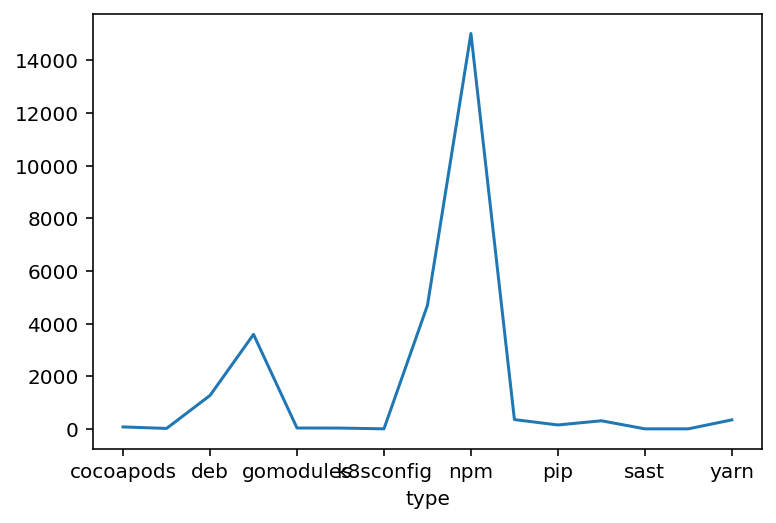

In [14]:
projectsFrame.groupby('type')['totalDependencies'].sum().plot()

A nicer way to see this is by using a bar chart. This is quite easy with pandas and matplot.

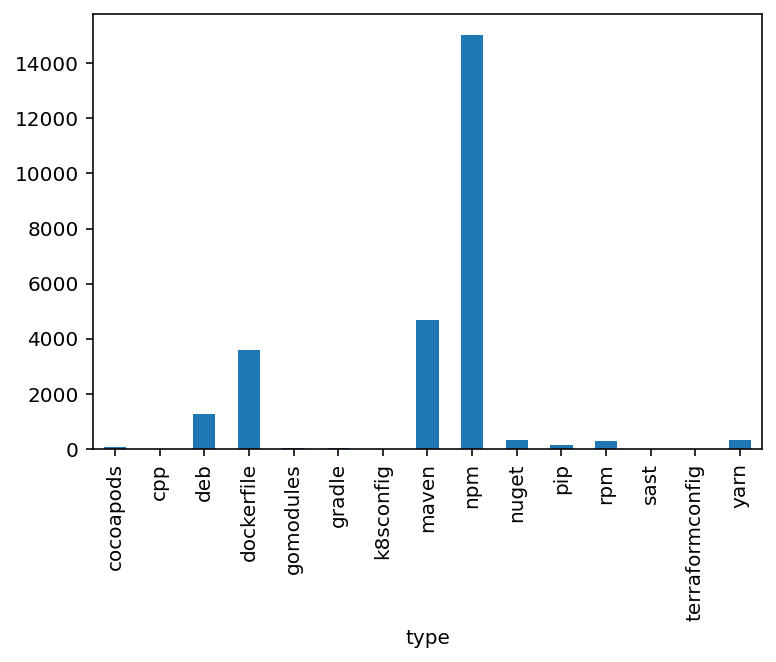

In [15]:
projectsFrame.groupby('type')['totalDependencies'].sum().plot.bar();

## Management tasks (add & remove tags)

You can use `pysnyk` in for other tasks as well.

In [54]:
TAG_NAME='business-unit'
TAG_VALUE='sir-christopher-wren'

# let's focus on a single project
project = client.projects.get(projects[0].id)

# check if we have the tags stored first - Snyks API is quite strict.
if { 'key': TAG_NAME, 'value': TAG_VALUE} in project.tags.all():
    project.tags.delete(TAG_NAME, TAG_VALUE)

In [55]:
project.tags.add(TAG_NAME, TAG_VALUE)

True

In [56]:
# notice how this is still empty!
print('Tags: {}'.format(project.tags.all()))

# reload it and try again
project = client.projects.get(projects[0].id)
      
print('Tags: {}'.format(project.tags.all()))

Tags: [{'key': 'business-unit', 'value': 'sir-christopher-wren'}]
Tags: [{'key': 'business-unit', 'value': 'sir-christopher-wren'}]
